In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time
from torch.utils.data import TensorDataset, DataLoader

In [16]:
df=pd.read_csv('../mydata/etth/ETTh.csv',index_col=0)
name='etth'
#将0列重命名为‘value’
df.rename(columns={'0':'value'},inplace=True)

In [2]:
df=pd.read_csv('../mydata/exchange/exchange.csv',index_col=0)
name='exchange'
#将0列重命名为‘value’
df.rename(columns={'0':'value'},inplace=True)

In [2]:
df=pd.read_csv('../mydata/牛仔裤/牛仔裤聚类数据.csv',index_col=0)
name='牛仔裤'
#将0列重命名为‘value’
df.rename(columns={'val':'value'},inplace=True)

In [2]:
df=pd.read_csv('../mydata/卫衣/卫衣聚类数据T.csv',index_col=0)
name='卫衣'

In [68]:
df=pd.read_csv('../mydata/毛衣/毛衣聚类数据T.csv',index_col=0)
name='毛衣'

<Axes: xlabel='date'>

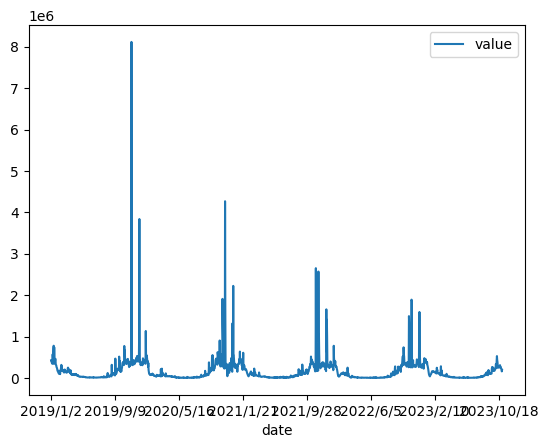

In [57]:
df.plot()

In [3]:
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [5]:
y = df['value'].values.astype(float)
test_size = 100
# 划分训练和测试集
window_size = 24
# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
y1 = scaler.fit_transform(y[:-test_size].reshape(-1, 1))
y2 = scaler.transform(y[-test_size:].reshape(-1, 1))
y = np.concatenate((y1, y2), axis=0)

In [8]:
# train_set = y[:-test_size]
# test_set = y[-test_size:]

In [6]:
# 转换为tensor
y = torch.FloatTensor(y).view(-1)
dataset = input_data(y,window_size)
#划分训练集与测试集
train_data = dataset[:-test_size]
test_data = dataset[-test_size:]



In [7]:
# train_data = input_data(train_norm,window_size)
# test_data = input_data(test_norm,window_size)
# 打印一组数据集
train_data[0]

(tensor([0.0235, 0.0284, 0.0259, 0.0237, 0.0290, 0.0249, 0.0400, 0.0309, 0.0344,
         0.0538, 0.0509, 0.0268, 0.0588, 0.0341, 0.0316, 0.0279, 0.0325, 0.0320,
         0.0245, 0.0264, 0.0227, 0.0194, 0.0201, 0.0205, 0.0172, 0.0143, 0.0167,
         0.0130, 0.0122, 0.0110]),
 tensor([0.0086]))

In [8]:
class CNNnetwork(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.kernel_size = 4
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigmoid = nn.Sigmoid()
        self.conv1d = nn.Conv1d(1,self.input_size,kernel_size=self.kernel_size)
        self.relu = nn.ReLU(inplace=True)
        self.Linear1= nn.Linear(self.input_size*(window_size+1-self.kernel_size),self.hidden_size)
        self.Linear2= nn.Linear(self.hidden_size,1)
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        return x

In [9]:
#将下列代码使用GPU
# torch.manual_seed(101)
model =CNNnetwork(input_size=64,hidden_size=128,output_size=1).to(device)
# 设置损失函数,这里使用的是均方误差损失
criterion = nn.MSELoss().to(device)
# 设置优化函数和学习率lr
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# 设置训练周期
epochs = 100
model.train()
start_time = time.time()
loss_list=[]
for epoch in range(epochs):
    loss_all=0
    predictions = []
    true=[]
    # for train_data in train_dataloader:
    for seq, y_train in train_data:
        # seq, y_train  = train_data[0],train_data[1]
        seq= seq.to(device)
        y_train = y_train.to(device)
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()
        # 注意这里要对样本进行reshape，
        # 转换成conv1d的input size（batch size, channel, series length）
        y_pred = model(seq.reshape(1,1,-1))
        loss = criterion(y_pred, y_train)
        predictions.append(y_pred.item())
        true.append(y_train.item())
        loss_all += loss.item()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_all)
    print(f'Epoch: {epoch+1:2} Loss: {loss_all:10.8f}')
# 绘制损失值迭代图
plt.plot(range(1, epochs + 1), loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#保存损失图和损失为csv
plt.savefig(f'loss/{name}_origin_loss.png')
losses = pd.DataFrame(loss_list)
losses.to_csv(f'loss/{name}_origin_losses.csv')
plt.show()
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 2.79580664
Epoch:  2 Loss: 2.71576220
Epoch:  3 Loss: 2.71238965
Epoch:  4 Loss: 2.71164576
Epoch:  5 Loss: 2.71147538
Epoch:  6 Loss: 2.71143620
Epoch:  7 Loss: 2.71142730
Epoch:  8 Loss: 2.71142544
Epoch:  9 Loss: 2.71142474
Epoch: 10 Loss: 2.71142454
Epoch: 11 Loss: 2.71142442
Epoch: 12 Loss: 2.71142442
Epoch: 13 Loss: 2.71142442


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(),f'{name}_model_origin.pth')

In [19]:
checkpoint = torch.load(f'{name}_model_origin.pth')
model.load_state_dict(checkpoint) # 这里checkpoint可以看为字典，和之前保存的state相对应

<All keys matched successfully>

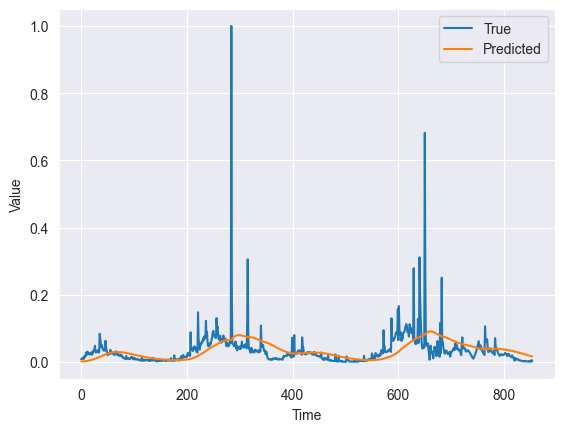

In [11]:
plt.plot(true, label='True')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [77]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_loss_all = 0
    predictions = []
    true=[]

    for seq, y_test in test_data:  # Assuming test_dataloader is your DataLoader for the test set
        seq = seq.to(device)
        y_test = y_test.to(device)

        # Make predictions
        y_pred = model(seq.reshape(1, 1, -1))

        # Calculate loss
        test_loss = criterion(y_pred, y_test)
        test_loss_all += test_loss.item()

        # Store predictions
        predictions.append(y_pred.item())
        true.append(y_test.item())

    # Calculate average test loss
    average_test_loss = test_loss_all
    print(f'Average Test Loss: {average_test_loss:.8f}')
#计算mae和mse
print('MAE:',mean_absolute_error(np.array(predictions[-100:]),np.array(true[-100:])))
print('MSE:',mean_squared_error(np.array(predictions[-100:]),np.array(true[-100:])))
#反归一化
predictions = scaler.inverse_transform(np.array(predictions[-100:]).reshape(-1, 1))
true = scaler.inverse_transform(np.array(true).reshape(-1, 1))
print('MAE:',mean_absolute_error(np.array(predictions[-100:]),np.array(true[-100:])))
print('MSE:',mean_squared_error(np.array(predictions[-100:]),np.array(true[-100:])))

Average Test Loss: 0.00525350
MAE: 0.004298082679742948
MSE: 5.253497853183745e-05
MAE: 34884.95826186566
MSE: 3460791564.37802


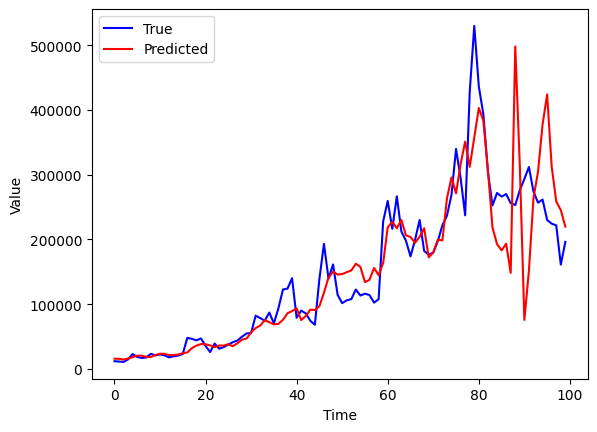

In [78]:
true_y=df.values[-100:]
# Plot true vs predicted values
plt.plot(true_y, label='True',color='BLUE')
plt.plot(predictions[-100:], label='Predicted',color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [79]:
#保存pre为csv
import os
if not os.path.exists(f'../mydata/{name}/cnn'):
    os.makedirs(f'../mydata/{name}/cnn')
pre=pd.DataFrame(predictions)
pre.to_csv(f'../mydata/{name}/cnn/{name}_pre_origin.csv')

# vmd
分解

In [117]:

df = pd.read_csv(f'../mydata/etth/optimal_modes_inorm_df.csv').T.iloc[1:, :]
#将df列名保存为列表
cols = df.columns.tolist()
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_size = 100
filename = 'etth'

In [95]:

df = pd.read_csv(f'../mydata/exchange/optimal_modes_inorm_df.csv').T.iloc[1:, :]
#将df列名保存为列表
cols = df.columns.tolist()
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_size = 100
filename = 'exchange'

In [6]:
df = pd.read_csv(f'../mydata/牛仔裤/optimal_modes_inorm_df.csv').T.iloc[1:, :]
#将df列名保存为列表
cols = df.columns.tolist()
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_size = 100
filename = '牛仔裤'


In [80]:
#卫衣
df = pd.read_csv(f'../mydata/卫衣/optimal_modes_inorm_df.csv').T.iloc[:-1, :]
#将df列名保存为列表
cols = df.columns.tolist()
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_size = 100
filename = '卫衣'


In [106]:
#毛衣
df = pd.read_csv(f'../mydata/毛衣/optimal_modes_inorm_df.csv').T.iloc[:-1, :]
#将df列名保存为列表
cols = df.columns.tolist()
#使用显卡
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_size = 100
filename = '毛衣'


In [107]:
name = [i for i in cols]

In [108]:


def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L - ws):
        window = seq[i:i + ws]
        label = seq[i + ws:i + ws + 1]
        out.append((window, label))
    return out

In [109]:

y_data = [df[i].values.astype(float) for i in cols]
# 划分训练和测试集
#best now 24 7 7

In [110]:
window_size = 24

In [111]:
scalers =[MinMaxScaler(feature_range=(0, 1)) for i in range(len(cols))]
y_data = [scalers[i].fit_transform(y_data[i].reshape(-1, 1)) for i in range(len(cols))]


In [112]:

# 转换为tensor
y_tensor =[torch.FloatTensor(y_data[i]).view(-1) for i in range(len(cols))
]
dataset = [input_data(y_tensor[i], window_size) for i in range(len(cols))]
#划分训练集与测试集
train_data = [y[:-test_size] for y in dataset]
test_data = [y[-test_size:] for y in dataset]

In [113]:

class CNNnetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,window_size):
        super().__init__()
        self.window_size = window_size
        self.kernel_size = 4
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigmoid = nn.Sigmoid()
        self.conv1d = nn.Conv1d(1, self.input_size, kernel_size=self.kernel_size)
        self.relu = nn.ReLU(inplace=True)
        self.Linear1 = nn.Linear(self.input_size * (self.window_size + 1 - self.kernel_size), self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        return x


In [114]:

#将下列代码使用GPU
torch.manual_seed(101)
models = [CNNnetwork(input_size=64, hidden_size=128, output_size=1,window_size=window_size).to(device) for i in range(len(cols))]

In [115]:
# 设置损失函数,这里使用的是均方误差损失
criterion = nn.MSELoss().to(device)
# 设置优化函数和学习率lr

optimizers =[torch.optim.SGD(models[i].parameters(), lr=1e-4) for i in range(len(cols))]


In [116]:
#定义一个函数控制所有模型是训练还是用来测试，用字符串来控制
def model_train_or_test(train_or_test):
    if train_or_test == 'train':
        for model_temp in models:
            model_temp.train()
    elif train_or_test == 'test':
        for model_temp in models:
            model_temp.eval()


In [117]:
# 设置训练周期
epochs = 150
model_train_or_test('train')
start_time = time.time()
predictions={str(i):[] for i in name}
true={str(i):[] for i in name}
loss_all = {str(i):[] for i in name}
for epoch in range(epochs):
    for model_temp,train_data_temp,name_temp,optimizer in zip(models,train_data,name,optimizers):
        loss_temp=0
        name_temp =str(name_temp)
        # for train_data in train_dataloader:
        for seq, y_train in train_data_temp:
            seq= seq.to(device)
            y_train = y_train.to(device)
            # 每次更新参数前都梯度归零和初始化
            # optimizer_zero()
            optimizer.zero_grad()
            # 注意这里要对样本进行reshape，
            # 转换成conv1d的input size（batch size, channel, series length）
            y_pred = model_temp(seq.reshape(1,1,-1))
            loss = criterion(y_pred, y_train)
            predictions[name_temp].append(y_pred.item())
            true[name_temp].append(y_train.item())
            loss_temp += loss.item()
            loss.backward()
            optimizer.step()
        loss_all[name_temp].append(loss_temp)
        
        print(f'Epoch: {epoch+1:2} name :{name_temp}  Loss: {loss_temp:10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 name :0  Loss: 81.77001230
Epoch:  1 name :1  Loss: 55.52220076
Epoch:  1 name :2  Loss: 26.20917068
Epoch:  1 name :3  Loss: 53.73260288
Epoch:  1 name :4  Loss: 45.40739291
Epoch:  1 name :5  Loss: 48.53361053
Epoch:  1 name :6  Loss: 29.57929467
Epoch:  1 name :7  Loss: 2.79340189
Epoch:  2 name :0  Loss: 23.07306368
Epoch:  2 name :1  Loss: 26.31516427
Epoch:  2 name :2  Loss: 10.71765888
Epoch:  2 name :3  Loss: 13.61673363
Epoch:  2 name :4  Loss: 7.88937509
Epoch:  2 name :5  Loss: 10.34400321
Epoch:  2 name :6  Loss: 12.32378676
Epoch:  2 name :7  Loss: 2.01297616
Epoch:  3 name :0  Loss: 14.26221185
Epoch:  3 name :1  Loss: 22.46136445
Epoch:  3 name :2  Loss: 9.94510926
Epoch:  3 name :3  Loss: 12.83612288
Epoch:  3 name :4  Loss: 7.65835664
Epoch:  3 name :5  Loss: 10.09225197
Epoch:  3 name :6  Loss: 11.80745736
Epoch:  3 name :7  Loss: 2.01230961
Epoch:  4 name :0  Loss: 11.33486493
Epoch:  4 name :1  Loss: 19.53281959
Epoch:  4 name :2  Loss: 9.30359791
Epoch:  

In [ ]:

train_data_temp= train_data[1]
model_temp = models[1]
name_temp = name[1]
loss_temp=0
# for train_data in train_dataloader:
for seq, y_train in train_data_temp:
    seq= seq.to(device)
    y_train = y_train.to(device)
    # 每次更新参数前都梯度归零和初始化
    # optimizer_zero()
    optimizer.zero_grad()
    # 注意这里要对样本进行reshape，
    # 转换成conv1d的input size（batch size, channel, series length）
    y_pred = model_temp(seq.reshape(1,1,-1))
    loss = criterion(y_pred, y_train)
    predictions[name_temp].append(y_pred.item())
    true[name_temp].append(y_train.item())
    loss_temp += loss.item()
    loss.backward()
    optimizer.step()
loss_all[name_temp].append(loss_temp)

print(f'Epoch: {epoch+1:2} name :{name_temp}  Loss: {loss_temp:10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [34]:

state = {str(i):models[i].state_dict() for i in range(len(cols))}
torch.save(state, f'{filename}_STL-x-model.pth') # state为一个字典，filename为保存的文件名称.pth


In [119]:
name = [i for i in cols]
model_train_or_test('test')  # Set the model to evaluation mode
with torch.no_grad():
    predictions={str(i):[] for i in name}
    true={str(i):[] for i in name}
    test_loss_all = {str(i): 0.0 for i in name}

    for model_temp, test_data_temp, name_temp in zip(models, test_data, name):
        test_loss_temp = 0
        name_temp = str(name_temp)
        for seq, y_test in test_data_temp:
            seq = seq.to(device)
            y_test = y_test.to(device)

            # Make predictions
            y_pred = model_temp(seq.reshape(1, 1, -1))

            # Calculate loss
            test_loss = criterion(y_pred, y_test)
            test_loss_temp += test_loss.item()

            # Store predictions
            predictions[name_temp].append(y_pred.item())
            true[name_temp].append(y_test.item())

        # Calculate average test loss for the current model
        average_test_loss = test_loss_temp / len(test_data_temp)
        test_loss_all[name_temp] = average_test_loss
        print(f'Average Test Loss for {name_temp}: {average_test_loss:.8f}')


Average Test Loss for 0: 0.00020620
Average Test Loss for 1: 0.00069135
Average Test Loss for 2: 0.00041238
Average Test Loss for 3: 0.00055267
Average Test Loss for 4: 0.00053647
Average Test Loss for 5: 0.00072401
Average Test Loss for 6: 0.00030613
Average Test Loss for 7: 0.00000436


# 未来预测

MAE: 0.012778385989367962
MSE: 0.00020619927760118882
MAE: 5654.578820886456
MSE: 40377152.84184504


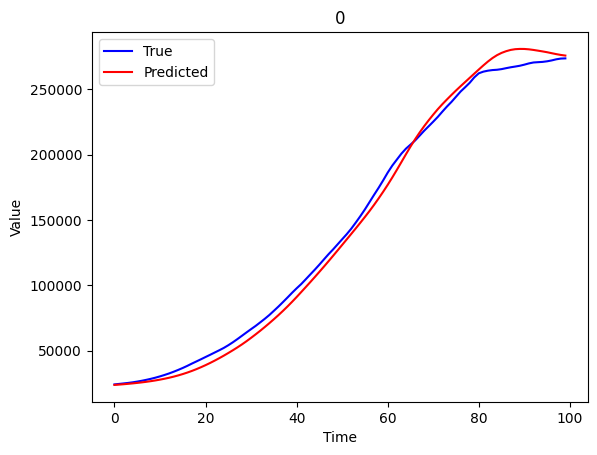

MAE: 0.017131305932998657
MSE: 0.0006913549555261689
MAE: 4803.644970217466
MSE: 54357814.67818053


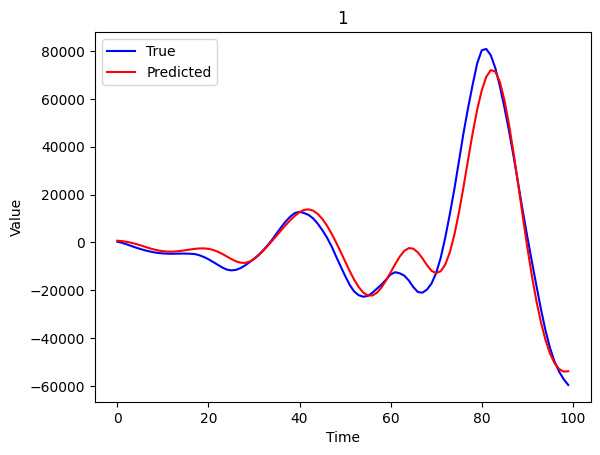

MAE: 0.014641212821006775
MSE: 0.0004123816771746114
MAE: 5018.416679840336
MSE: 48448320.00002479


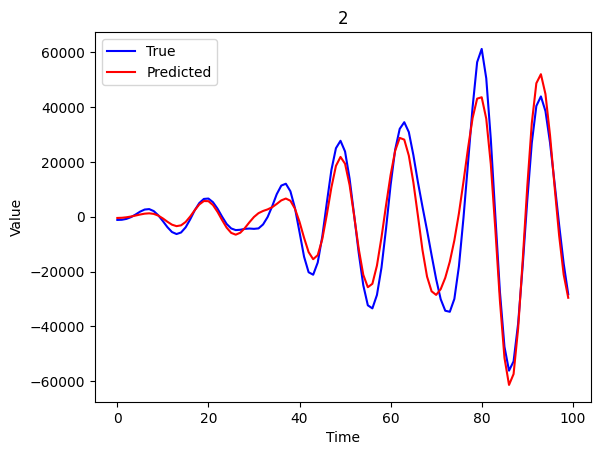

MAE: 0.016532443165779113
MSE: 0.0005526662373507207
MAE: 3600.0181309836557
MSE: 26205848.547540236


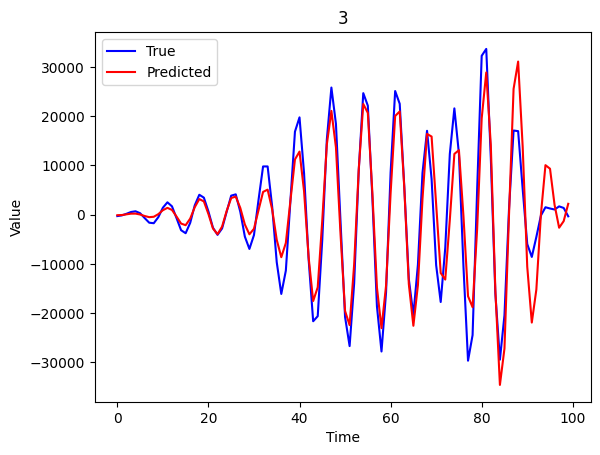

MAE: 0.014768305420875549
MSE: 0.0005364713190445514
MAE: 3190.1847616149707
MSE: 25033226.8287752


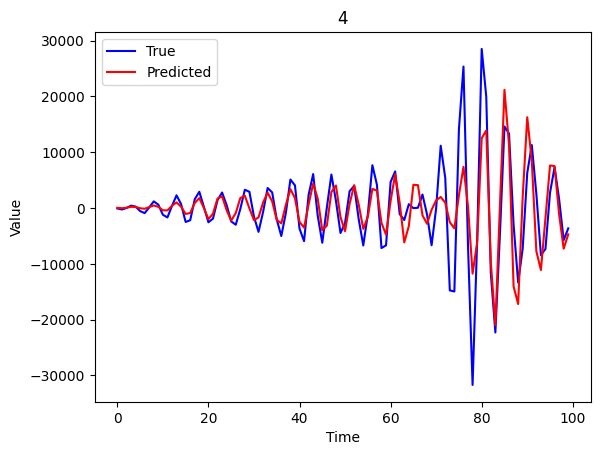

MAE: 0.019835284650325774
MSE: 0.0007240119481784912
MAE: 2688.8771888417855
MSE: 13304875.145687716


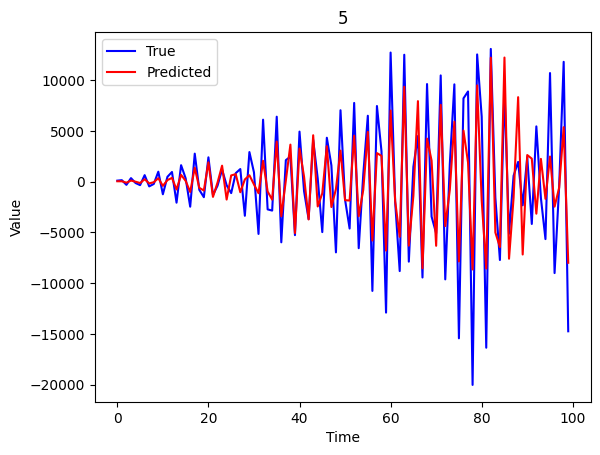

MAE: 0.012971207201480865
MSE: 0.0003061342708532155
MAE: 1460.7104412122376
MSE: 3882213.6863721106


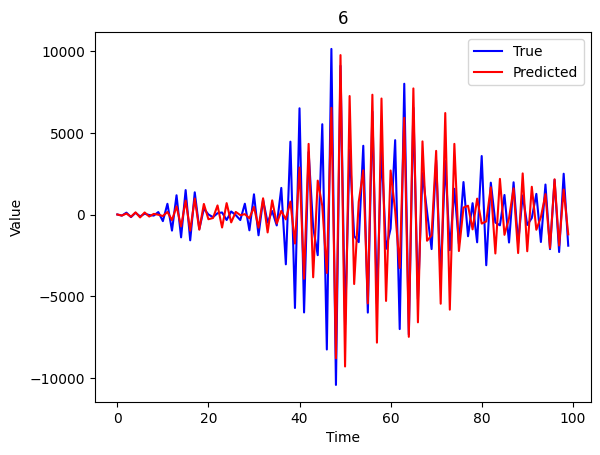

MAE: 0.0020583307649940253
MSE: 4.359085539577773e-06
MAE: 16043.928195726037
MSE: 264841767.10738045


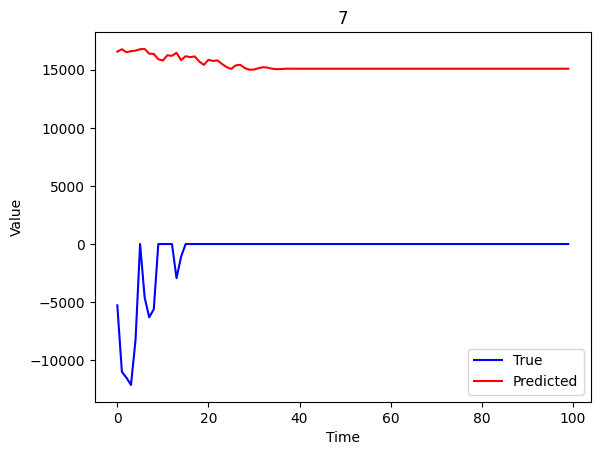

In [120]:

for name_temp,i in zip(name,range(len(name))):
    #计算mae和mse
    name_temp = str(name_temp)
    print('MAE:', mean_absolute_error(np.array(predictions[name_temp][-100:]), np.array(true[name_temp])))
    print('MSE:', mean_squared_error(np.array(predictions[name_temp][-100:]), np.array(true[name_temp])))
    #反归一化
    predictions_1 = scalers[i].inverse_transform(np.array(predictions[name_temp][-100:]).reshape(-1, 1))
    # true_1 = scaler[i].inverse_transform(np.array(true[name_temp]).reshape(-1, 1))
    name_temp = int(name_temp)
    true_y = df[name_temp].values[-100:]
    print('MAE:', mean_absolute_error(np.array(predictions_1[-100:]), np.array(true_y)))
    print('MSE:', mean_squared_error(np.array(predictions_1[-100:]), np.array(true_y)))
    # Plot true vs predicted values
    plt.plot(true_y, label='True',color='blue')
    plt.plot(predictions_1, label='Predicted',color='red')
    plt.title(name_temp)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    

In [121]:
predictions1= {}
predictions2= {}
for i,j in zip(name,range(len(name))):
    i=str(i)
    predictions[i] = scalers[j].inverse_transform(np.array(predictions[i]).reshape(-1, 1))
    predictions2[i] = predictions[i].reshape(-1).tolist()

In [122]:
#保存predictions为csv
pre = pd.DataFrame(predictions2)
pre.to_csv(f'{filename}vmdpre.csv')

In [123]:
#保存pre为csv
pre = pd.DataFrame(predictions2)
pre.to_csv(f'{filename}pre.csv')
#predictions的值反归一化



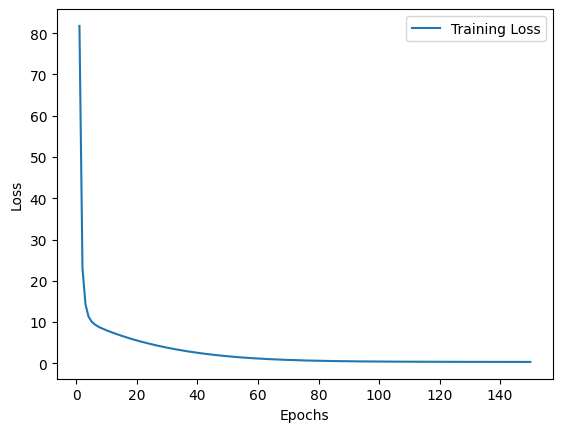

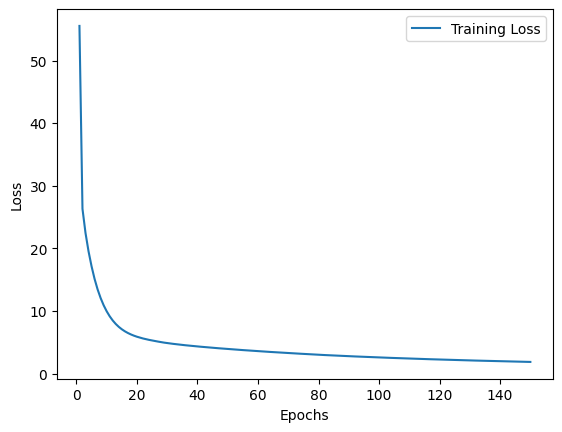

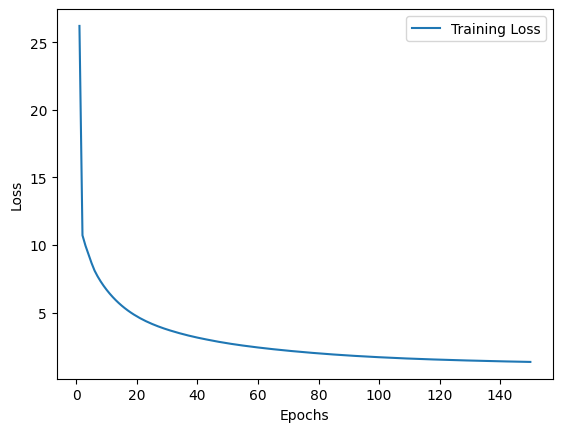

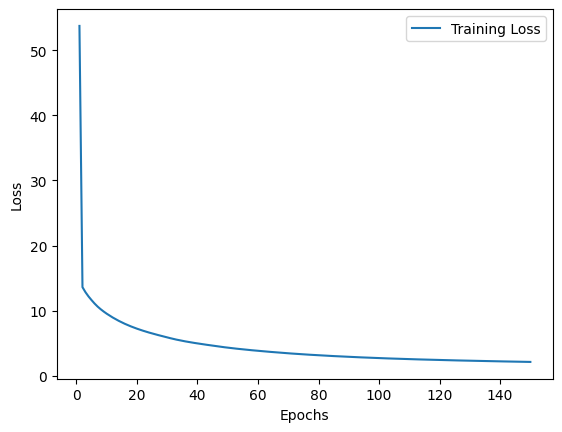

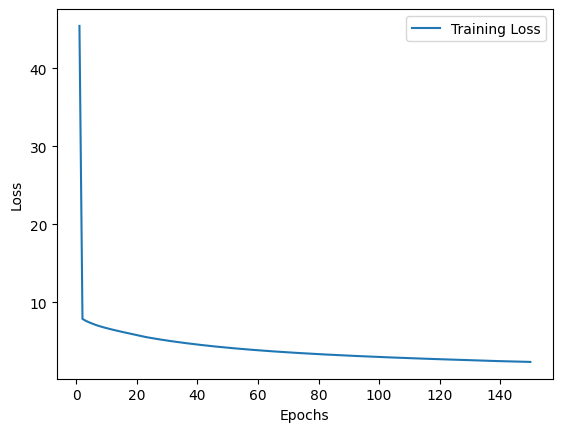

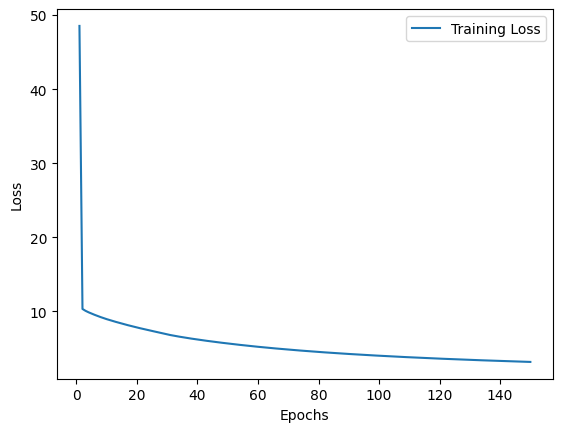

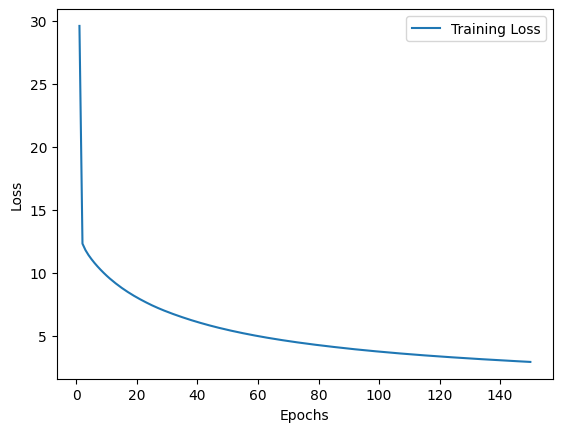

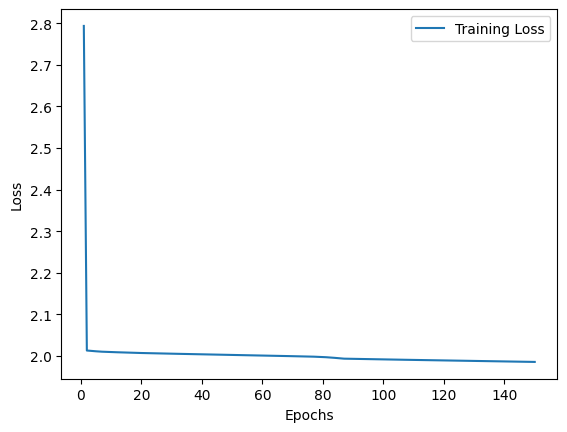

In [124]:
#将loss_all所有值绘制出来
for i in name:
    i=str(i)
    plt.plot(range(1, epochs + 1), loss_all[i], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #保存损失图和损失为csv
    plt.savefig(f'loss/{filename}{i}_loss.png')
    losses = pd.DataFrame(loss_all[i])
    losses.to_csv(f'loss/{filename}{i}_losses.csv')
    plt.show()

In [125]:
#保存损失
Loss = pd.DataFrame(loss_all)
Loss.to_csv(f'loss/{filename}loss_stl.csv')

# 乘法预测

In [126]:
from functools import reduce
def dict_multiply(dict):
    return reduce(lambda x,y:x+y,dict.values())

In [128]:
pred=dict_multiply(predictions)

In [72]:
df = pd.read_csv('../mydata/etth/ETTh.csv', parse_dates=True)
df.rename(columns={0: 'value'}, inplace=True)

In [109]:
df = pd.read_csv('../mydata/exchange/exchange.csv', parse_dates=True)
df.rename(columns={0: 'value'}, inplace=True)

In [43]:
df = pd.read_csv('../mydata/牛仔裤/牛仔裤聚类数据.csv', parse_dates=True)
df.rename(columns={'val': 'value'}, inplace=True)

In [102]:
#卫衣
df = pd.read_csv('../mydata/卫衣/卫衣聚类数据T.csv', parse_dates=True)


In [127]:
#毛衣
df = pd.read_csv('../mydata/毛衣/毛衣聚类数据T.csv', parse_dates=True)

In [129]:
true_y=df.values[-101:-1][:,1:]

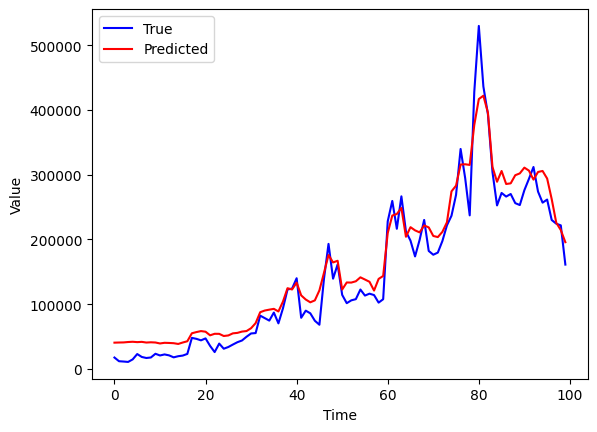

MAE: 22217.523995324515
MSE: 738232623.7437421


In [130]:
# Plot true vs predicted values
plt.plot(true_y, label='True',color='blue')
plt.plot(pred, label='Predicted',color='red')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
#打印误差

print('MAE:',mean_absolute_error(true_y,pred))
print('MSE:',mean_squared_error(true_y,pred))


In [131]:
pre = pd.DataFrame(pred)
pre.to_csv(f'../mydata/{filename}/cnn/{filename}pre_VMD_result.csv')